# BidMPH v2 Monitor <br> Arica

## Imports

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [54]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [55]:
CITY_ID = 4267
CITY_NAME = 'Arica'
ORDER_TYPE = 'auto_econom'

In [56]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [57]:
start_date = '2025-05-01'
end_date = '2025-06-20'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

df_total saved as Arica_total_bids.csv


df0 ('Before')

In [ ]:
start_date = '2025-05-01'
end_date = '2025-05-19'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-05-01 00:00:09+00:00 
 to 2025-05-19 23:59:57+00:00
df0 saved as Arica_before_bids.csv


df1 ('Test')

In [214]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-20 00:00:04+00:00 
 to 2025-05-22 07:47:42+00:00
df1 saved as Arica_test_bids.csv


## Process Data

In [60]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [61]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_28554/2169941879.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')


In [62]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [63]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

df1

In [64]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_28554/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [65]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

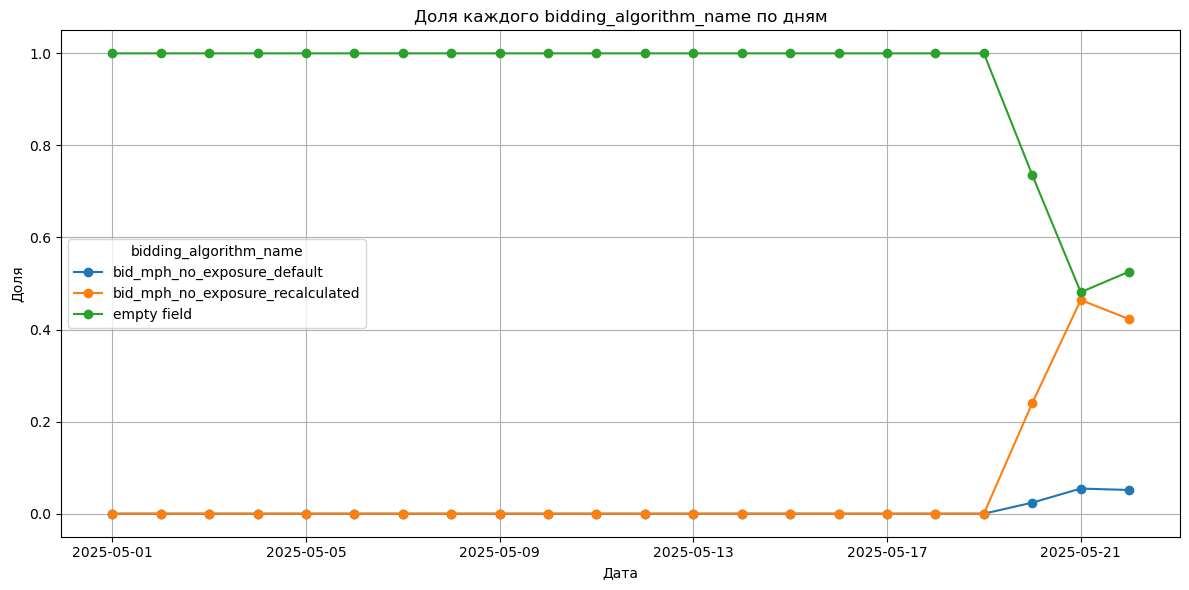

In [66]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [67]:
df0['bidding_algorithm_name'].unique()

array(['empty field'], dtype=object)

In [68]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=3)

In [69]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'empty field': 1.0}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 1.0,
 'total': 943759}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.25,
                'share': 0.0},
 'between_0_1': {'done_share': 0.7143,
                 'share': 0.0},
 'between_1_2': {'done_share': 0.5,
                 'share': 0.0},
 'match_first': {'done_share': 0.2343,
                 'share': 0.0501},
 'match_second': {'done_share': 0.1185,
                  'share': 0.219},
 'match_sp': {'done_share': 0.4305,
              'share': 0.6217},
 'match_third': {'done_share': 0.0523,
                 'share': 0.1065}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_2': {'above_last': {'done_share': nan,
                          'share': 0.0},
           'between_0_1': {'done_share': nan,
                           'shar

In [70]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.6243882177547446 0.05009011834589127 0.21899764664495916 0.10650600418115218


df1

In [71]:
df1['bidding_algorithm_name'].unique()

array(['bid_mph_no_exposure_default', 'bid_mph_no_exposure_recalculated',
       'empty field'], dtype=object)

In [72]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=3)

In [73]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0397,
 'bid_mph_no_exposure_recalculated': 0.3536,
 'empty field': 0.6067}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0001,
 'len_2': 0.0,
 'len_3': 0.9999,
 'total': 63208}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': nan,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.2311,
                 'share': 0.0483},
 'match_second': {'done_share': 0.1154,
                  'share': 0.2158},
 'match_sp': {'done_share': 0.4009,
              'share': 0.6182},
 'match_third': {'done_share': 0.0538,
                 'share': 0.1137}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': nan,
                          'sh

In [74]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=3)

In [75]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0397,
 'bid_mph_no_exposure_recalculated': 0.3536,
 'empty field': 0.6067}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.6333,
 'len_2': 0.1883,
 'len_3': 0.1784,
 'total': 40975}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': nan,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.1827,
                 'share': 0.1482},
 'match_second': {'done_share': 0.1092,
                  'share': 0.0997},
 'match_sp': {'done_share': 0.391,
              'share': 0.7049},
 'match_third': {'done_share': 0.0559,
                 'share': 0.0423}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': nan,
                          '

## !

In [276]:
columns = ['bid_uuid', 'etr', 'eta', 'price_highrate_value', 'price_start_value', 'bid_price_currency', 
           'steps_recalc_default', 'bidding_algorithm_name', 'available_prices_currency', 
           'steps_real_perc', 'max_bid']

t = 193
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [350]:
def calculate_max_bid(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    # max_bid = (1+alpha) * max(Rec_price, Start_price) * (1 + (1+alpha) * max[0, (t2-t)]/(t1+t))
    max_bid = (1 + alpha) * max_price * (1 + time_diff_max / (t1 + t))

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [351]:
df_tmp = df1.sample(n=5).copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] != 'empty field'][columns].transpose()

,76635,102705,62158
bid_uuid,0196f048-54b5-7fd5-94fe-b3f64467543d,0196f4fa-6e83-7113-8056-208cc61ec4ea,0196ef5b-d51a-792b-aab9-64bf4a66aa37
etr,718,1326,165
eta,420,480,240
price_highrate_value,2500.0,3170.0,1580.0
price_start_value,2750.0,3500.0,2000.0
bid_price_currency,3050.0,3500.0,2000.0
steps_recalc_default,"[3025.0000000000005, 3300.0, 3575.0]","[3850.0000000000005, 4200.0, 4550.0]","[2200.0, 2400.0, 2600.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[3050.0, 3150.0]","[3850.0, 4200.0, 4250.0]",[2200.0]
steps_real_perc,"[1.1090909090909091, 1.1454545454545455]","[1.1, 1.2, 1.2142857142857142]",[1.1]


Случай, где max_bid больше третьей опции, но bid_mph_no_exposure_recalculated <br>
bid_uuid = '0196f019-0107-7609-a6ed-2f50ea1ab684'

In [398]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['case_check']].transpose()

,0,2,3,4,5,6,7,8,10,12,...,104244,104246,104247,104249,104260,104262,104264,104270,104274,104277
bid_uuid,0196f6e8-0900-7b81-a505-c5bd64186998,0196f023-08a9-7ac2-b3d9-db57b348889e,0196f53e-ae42-792e-a221-81d370098342,0196ee25-14c7-7905-a771-8499a6528caa,0196f1a5-4dc2-7352-9acf-fa2c0ae4d749,0196f1a5-a913-72fb-9cf9-cc7fe5402347,0196f19d-88c8-734e-bf95-cc7e9175f261,0196f188-06cd-72ea-9307-6aec533e8f91,0196f65a-d6b7-7ccf-a065-627c263f5091,0196f45f-527b-7db3-8fa8-455968dede87,...,0196f1b2-0760-735a-b23f-7eb742e65c13,0196f50c-cd6a-7b4e-8978-4479af415ec6,0196f107-b913-748f-ac88-dd17a971d79e,0196f406-f6df-7c03-86c2-4ac552775836,0196f502-6747-7290-b1be-71bd79ade5a2,0196f60a-c382-7419-a26f-4da0ae618c29,0196f215-042a-7334-8e2c-ff79b633db13,0196f276-932c-7815-a297-a19edb4d4345,0196f0c7-ece3-73cb-a3bb-f4e2960af229,0196f6a8-de7c-7c12-8395-02161a2ca003
etr,<NA>,862,778,127,589,182,791,1532,458,270,...,371,986,992,1407,1027,718,467,351,611,<NA>
eta,300,240,300,180,180,180,300,420,420,120,...,180,660,240,420,540,240,180,120,240,480
price_highrate_value,2240.0,2710.0,2570.0,1570.0,2660.0,2140.0,3020.0,4010.0,2620.0,1720.0,...,2500.0,3000.0,3500.0,4000.0,3060.0,3000.0,3000.0,2500.0,2500.0,3710.0
price_start_value,2240.0,2710.0,2570.0,1500.0,3410.0,2140.0,3020.0,5000.0,2800.0,1720.0,...,4000.0,4000.0,4000.0,5000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
bid_price_currency,2240.0,3000.0,2850.0,1750.0,3410.0,2140.0,3020.0,5950.0,2800.0,1720.0,...,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
steps_recalc_default,"[2464.0, 2688.0, 2912.0]","[2981.0000000000005, 3252.0, 3523.0]","[2827.0000000000005, 3084.0, 3341.0]","[1650.0000000000002, 1800.0, 1950.0]","[3751.0000000000005, 4092.0, 4433.0]","[2354.0, 2568.0, 2782.0]","[3322.0000000000005, 3624.0, 3926.0]","[5500.0, 6000.0, 6500.0]","[3080.0000000000005, 3360.0, 3640.0]","[1892.0000000000002, 2064.0, 2236.0]",...,"[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[5500.0, 6000.0, 6500.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[2500.0, 2550.0]",[3000.0],[2850.0],"[1650.0, 1750.0]",[3800.0],[2400.0],"[3350.0, 3400.0]","[5500.0, 5950.0]","[3100.0, 3400.0, 3550.0]",[1900.0],...,[4400.0],"[4400.0, 4700.0]",[4400.0],"[4400.0, 4500.0]","[4400.0, 4600.0]",[4400.0],[4400.0],[4400.0],[4400.0],"[4400.0, 4800.0, 4950.0]"
steps_real_perc,"[1.1160714285714286, 1.1383928571428572]",[1.1070110701107012],[1.1089494163424125],"[1.1, 1.1666666666666667]",[1.1143695014662756],[1.1214953271028036],"[1.109271523178808, 1.1258278145695364]","[1.1, 1.19]","[1.1071428571428572, 1.2142857142857142, 1.267...",[1.1046511627906976],...,[1.1],"[1.1, 1.175]",[1.1],"[0.88, 0.9]","[1.1, 1.15]",[1.1],[1.1],[1.1],[1.1],"[1.1, 1.2, 1.2375]"


In [399]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.954820
                                  True          0.045180
bid_mph_no_exposure_recalculated  False         0.197253
                                  True          0.802747
empty field                       False         0.250802
                                  True          0.749198
dtype: float64

In [400]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].sample(n=5)[columns].transpose()

,28574,91956,72639,13387,51597
bid_uuid,0196f0a5-3c00-7fc1-8c37-caacffc6fe90,0196f3f7-f548-76bb-93cb-2ba04daee783,0196f07b-b8fb-776f-b3b2-a169c5a9a9f7,0196f6e8-1118-7b81-a662-4b17ec3eefd7,0196eeb0-7c29-7638-a6b7-40998c571853
etr,178,840,296,<NA>,496
eta,300,420,480,240,300
price_highrate_value,2000.0,3000.0,2020.0,2240.0,2130.0
price_start_value,2000.0,3000.0,2500.0,2240.0,2000.0
bid_price_currency,2000.0,3000.0,3000.0,2500.0,2000.0
steps_recalc_default,"[2200.0, 2400.0, 2600.0]","[3300.0000000000005, 3600.0, 3900.0]","[2750.0, 3000.0, 3250.0]","[2464.0, 2688.0, 2912.0]","[2200.0, 2400.0, 2600.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[2200.0],[3300.0],"[2750.0, 3000.0, 3250.0]",[2500.0],"[2200.0, 2350.0]"
steps_real_perc,[1.1],[1.1],"[1.1, 1.2, 1.3]",[1.1160714285714286],"[1.1, 1.175]"


In [401]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].to_csv('recalculated_false_cases.csv', index=False)

Sabr MaxBid

In [356]:
t = 193
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = max(row['eta'], t)
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [374]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,2,3,4,5,6,7,8,10,12,...,104244,104246,104247,104249,104260,104262,104264,104270,104274,104277
bid_uuid,0196f6e8-0900-7b81-a505-c5bd64186998,0196f023-08a9-7ac2-b3d9-db57b348889e,0196f53e-ae42-792e-a221-81d370098342,0196ee25-14c7-7905-a771-8499a6528caa,0196f1a5-4dc2-7352-9acf-fa2c0ae4d749,0196f1a5-a913-72fb-9cf9-cc7fe5402347,0196f19d-88c8-734e-bf95-cc7e9175f261,0196f188-06cd-72ea-9307-6aec533e8f91,0196f65a-d6b7-7ccf-a065-627c263f5091,0196f45f-527b-7db3-8fa8-455968dede87,...,0196f1b2-0760-735a-b23f-7eb742e65c13,0196f50c-cd6a-7b4e-8978-4479af415ec6,0196f107-b913-748f-ac88-dd17a971d79e,0196f406-f6df-7c03-86c2-4ac552775836,0196f502-6747-7290-b1be-71bd79ade5a2,0196f60a-c382-7419-a26f-4da0ae618c29,0196f215-042a-7334-8e2c-ff79b633db13,0196f276-932c-7815-a297-a19edb4d4345,0196f0c7-ece3-73cb-a3bb-f4e2960af229,0196f6a8-de7c-7c12-8395-02161a2ca003
etr,<NA>,862,778,127,589,182,791,1532,458,270,...,371,986,992,1407,1027,718,467,351,611,<NA>
eta,300,240,300,180,180,180,300,420,420,120,...,180,660,240,420,540,240,180,120,240,480
price_highrate_value,2240.0,2710.0,2570.0,1570.0,2660.0,2140.0,3020.0,4010.0,2620.0,1720.0,...,2500.0,3000.0,3500.0,4000.0,3060.0,3000.0,3000.0,2500.0,2500.0,3710.0
price_start_value,2240.0,2710.0,2570.0,1500.0,3410.0,2140.0,3020.0,5000.0,2800.0,1720.0,...,4000.0,4000.0,4000.0,5000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
bid_price_currency,2240.0,3000.0,2850.0,1750.0,3410.0,2140.0,3020.0,5950.0,2800.0,1720.0,...,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
steps_recalc_default,"[2464.0, 2688.0, 2912.0]","[2981.0000000000005, 3252.0, 3523.0]","[2827.0000000000005, 3084.0, 3341.0]","[1650.0000000000002, 1800.0, 1950.0]","[3751.0000000000005, 4092.0, 4433.0]","[2354.0, 2568.0, 2782.0]","[3322.0000000000005, 3624.0, 3926.0]","[5500.0, 6000.0, 6500.0]","[3080.0000000000005, 3360.0, 3640.0]","[1892.0000000000002, 2064.0, 2236.0]",...,"[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[5500.0, 6000.0, 6500.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[2500.0, 2550.0]",[3000.0],[2850.0],"[1650.0, 1750.0]",[3800.0],[2400.0],"[3350.0, 3400.0]","[5500.0, 5950.0]","[3100.0, 3400.0, 3550.0]",[1900.0],...,[4400.0],"[4400.0, 4700.0]",[4400.0],"[4400.0, 4500.0]","[4400.0, 4600.0]",[4400.0],[4400.0],[4400.0],[4400.0],"[4400.0, 4800.0, 4950.0]"
steps_real_perc,"[1.1160714285714286, 1.1383928571428572]",[1.1070110701107012],[1.1089494163424125],"[1.1, 1.1666666666666667]",[1.1143695014662756],[1.1214953271028036],"[1.109271523178808, 1.1258278145695364]","[1.1, 1.19]","[1.1071428571428572, 1.2142857142857142, 1.267...",[1.1046511627906976],...,[1.1],"[1.1, 1.175]",[1.1],"[0.88, 0.9]","[1.1, 1.15]",[1.1],[1.1],[1.1],[1.1],"[1.1, 1.2, 1.2375]"


In [375]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.954820
                                  True          0.045180
bid_mph_no_exposure_recalculated  False         0.197253
                                  True          0.802747
empty field                       False         0.250802
                                  True          0.749198
dtype: float64

Before experiment

In [377]:
t = 193
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [378]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

""
bid_uuid
etr
eta
price_highrate_value
price_start_value
bid_price_currency
steps_recalc_default
bidding_algorithm_name
available_prices_currency
steps_real_perc


In [386]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
empty field             False         0.255068
                        True          0.744932
dtype: float64

Affected bids (not steps)

In [390]:
t = 193
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [396]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['bid_price_currency'], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,944837,944838,944839,944840,944841,944842,944843,944844,944845,944846
bid_uuid,0196c29e-250d-7ca0-9c30-0c42e4988aaf,0196c47b-6642-76f1-aeba-63e5430998de,0196c6e3-d7cf-7046-bc87-36b6416d3c69,0196c6e5-e374-7ae2-b438-73f3de3d3bb1,01968eb7-2322-7581-8618-9e54a53fb446,01968ea9-f7b4-78cc-9fd0-829dab3d5a4e,01969288-1d18-752a-a44a-5cc9d88f45ab,019692f2-8d5b-7175-8ac5-e5cf189384b7,0196e95e-f862-7268-8505-0d72662c5d20,0196ea0c-db58-7537-8f39-17954628d7ee,...,0196b458-8181-71b1-858a-8f04d96f0ffb,0196b833-9982-7082-a9e0-ddc33c7db5b6,0196b29d-2eb7-78c2-9948-facb64071967,0196b31f-6b5f-7a7f-ac81-6bb966f0d007,0196b31b-730f-7a77-bd56-f38877d715fd,0196b61e-ac08-7e3e-b814-099888ae43c2,0196b296-fef1-7e37-b4a4-9950e6b7bb8c,0196b268-bf52-7d9a-91d5-78f38c1edfa0,0196b717-d0f8-7af6-950a-3828b9933984,0196b7c6-926b-7ecd-9304-8824a3d5742a
etr,213,398,608,943,860,0,602,622,1059,315,...,300,493,902,290,753,1113,595,783,587,791
eta,540,240,300,420,180,300,360,240,120,180,...,120,360,120,120,180,300,180,300,120,180
price_highrate_value,2030.0,2000.0,2500.0,3000.0,3170.0,NaN,2690.0,2540.0,3030.0,2000.0,...,2070.0,2220.0,2680.0,2000.0,2660.0,3000.0,2500.0,2650.0,2500.0,2630.0
price_start_value,2030.0,2000.0,4000.0,3500.0,3500.0,3250.0,2690.0,2540.0,5000.0,1800.0,...,3000.0,3000.0,3000.0,3000.0,2500.0,3000.0,3000.0,2700.0,2500.0,3000.0
bid_price_currency,2030.0,2400.0,5200.0,4200.0,3500.0,3250.0,2690.0,2800.0,5000.0,2000.0,...,3000.0,3000.0,3000.0,3000.0,3000.0,3600.0,3000.0,2700.0,3000.0,3000.0
steps_recalc_default,"[2233.0, 2436.0, 2639.0]","[2200.0, 2400.0, 2600.0]","[4400.0, 4800.0, 5200.0]","[3850.0000000000005, 4200.0, 4550.0]","[3850.0000000000005, 4200.0, 4550.0]","[3575.0000000000005, 3900.0, 4225.0]","[2959.0000000000005, 3228.0, 3497.0]","[2794.0, 3048.0, 3302.0]","[5500.0, 6000.0, 6500.0]","[1980.0000000000002, 2160.0, 2340.0]",...,"[3300.0000000000005, 3600.0, 3900.0]","[3300.0000000000005, 3600.0, 3900.0]","[3300.0000000000005, 3600.0, 3900.0]","[3300.0000000000005, 3600.0, 3900.0]","[2750.0, 3000.0, 3250.0]","[3300.0000000000005, 3600.0, 3900.0]","[3300.0000000000005, 3600.0, 3900.0]","[2970.0000000000005, 3240.0, 3510.0]","[2750.0, 3000.0, 3250.0]","[3300.0000000000005, 3600.0, 3900.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[2250.0, 2450.0, 2650.0]","[2200.0, 2400.0, 2600.0]","[4400.0, 4800.0, 5200.0]","[3850.0, 4200.0, 4550.0]","[3850.0, 4200.0, 4550.0]","[3600.0, 3900.0, 4250.0]","[3000.0, 3250.0, 3500.0]","[2800.0, 3050.0, 3350.0]","[5500.0, 6000.0, 6500.0]","[2000.0, 2200.0, 2350.0]",...,"[3300.0, 3600.0, 3900.0]","[3300.0, 3600.0, 3900.0]","[3300.0, 3600.0, 3900.0]","[3300.0, 3600.0, 3900.0]","[2750.0, 3000.0, 3250.0]","[3300.0, 3600.0, 3900.0]","[3300.0, 3600.0, 3900.0]","[3000.0, 3250.0, 3550.0]","[2750.0, 3000.0, 3250.0]","[3300.0, 3600.0, 3900.0]"
steps_real_perc,"[1.1083743842364533, 1.206896551724138, 1.3054...","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1076923076923078, 1.2, 1.3076923076923077]","[1.1152416356877324, 1.20817843866171, 1.30111...","[1.1023622047244095, 1.2007874015748032, 1.318...","[1.1, 1.2, 1.3]","[1.1111111111111112, 1.2222222222222223, 1.305...",...,"[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1111111111111112, 1.2037037037037037, 1.314...","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]"


In [395]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
empty field             False         0.809354
                        True          0.190646
dtype: float64

Choose Cities Query

In [383]:
def bids_data(start_date, stop_date, printBool=False):
    tmp_query = f"""
-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) AS first_row_by_accepted_tender,
    FROM `indriver-e6e40.emart.incity_detail`
    WHERE TRUE
        AND created_date_order_part >= DATE_SUB(DATE('{start_date}'), INTERVAL 1 DAY)
        AND created_date_order_part <= DATE_ADD(DATE('{stop_date}'), INTERVAL 1 DAY)
        AND DATE(TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', order_timestamp), timezone)) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

incity_details_base AS (
  SELECT *
  FROM incity_details_raw
  WHERE first_row_by_accepted_tender = 1
),

avg_rta_per_city_type AS (
    SELECT
        city_id,
        order_type,
        AVG(TIMESTAMP_DIFF(driverarrived_timestamp, driveraccept_timestamp, SECOND)) AS avg_rta_seconds_t -- This is 't'
    FROM incity_details_base
    WHERE is_order_arrived = TRUE
    GROUP BY city_id, order_type
),

order_global_info AS (
    SELECT
        uuid AS order_uuid,
        MAX(multiplier) AS multiplier,
        MAX(price_highrate_value / COALESCE(multiplier, 100)) AS price_highrate_value,
        MAX(payment_price_value / COALESCE(multiplier, 100)) AS price_start_value
    FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm`
    WHERE uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) >= DATE('{start_date}') 
      AND DATE(created_at) <= DATE('{stop_date}')
    GROUP BY uuid
),

bids_raw AS (
    SELECT
        uuid AS bid_uuid,
        order_uuid,
        price AS bid_price_value,
        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64) AS t2_eta_seconds, -- This is 't2'
        created_at AS utc_bid_dttm
    FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
    WHERE status = 'BID_STATUS_ACTIVE'
      AND order_uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

bids_enriched AS (
    SELECT
        b_raw.bid_uuid,
        b_raw.order_uuid,
        b_raw.utc_bid_dttm,
        b_raw.t2_eta_seconds,
        idb.city_id,
        idb.order_type,
        idb.tender_uuid AS order_accepted_tender_uuid,
        idb.is_order_done,
        idb.t1_duration_seconds,
        ogi.price_highrate_value,
        ogi.price_start_value,
        idb.start_price_incity_usd, -- Start_price (from incity_detail, for reference or alternative)
        b_raw.bid_price_value / COALESCE(ogi.multiplier, 100) AS bid_price_value,
        art.avg_rta_seconds_t
    FROM bids_raw b_raw
    LEFT JOIN incity_details_base idb ON b_raw.order_uuid = idb.order_uuid
    LEFT JOIN order_global_info ogi ON b_raw.order_uuid = ogi.order_uuid
    LEFT JOIN avg_rta_per_city_type art ON idb.city_id = art.city_id AND idb.order_type = art.order_type
),

-- Evaluate bids based on the formula
evaluated_bids AS (
    SELECT
        be.*,
        av.alpha_value,
        -- max_permissible_bid formula: (1+alpha) * max(Rec_price, Start_price) * (1 + max(0, (t2-t))/(t1+t))
        ( (1 + av.alpha_value) * GREATEST(COALESCE(be.price_highrate_value, 0), COALESCE(be.price_start_value, 0)) * -- Using COALESCE for safety, though filters should handle NULLs
            (1 + GREATEST(0, COALESCE(be.t2_eta_seconds, 0) - COALESCE(be.avg_rta_seconds_t, 0)) /
                 NULLIF( (COALESCE(be.t1_duration_seconds, 0) + COALESCE(be.avg_rta_seconds_t, 0)) , 0)
            )
        ) AS max_permissible_bid
    FROM bids_enriched be
    CROSS JOIN alpha_values av
    WHERE be.price_highrate_value IS NOT NULL      
      AND be.price_start_value IS NOT NULL 
      AND be.t1_duration_seconds IS NOT NULL 
      -- avg_rta_seconds_t (t) can be null (coalesced to 0 in formula)
      -- t2_eta_seconds (t2) can be null (coalesced to 0 in formula)
),

bids_with_bad_status AS (
    SELECT
        *,
        (max_permissible_bid IS NOT NULL AND bid_price_value > max_permissible_bid) AS is_bad_bid
    FROM evaluated_bids
),

-- Metric 1: Доля плохих бидов
overall_bad_bid_share AS (
    SELECT
        city_id,
        order_type,
        avg_rta_seconds_t,
        alpha_value,
        COUNTIF(max_permissible_bid IS NOT NULL) AS total_bids_rule_applicable,
        SUM(CAST(is_bad_bid AS INT64)) AS count_bad_bids,
        SAFE_DIVIDE(SUM(CAST(is_bad_bid AS INT64)), COUNTIF(max_permissible_bid IS NOT NULL)) AS share_of_bad_bids
    FROM bids_with_bad_status
    GROUP BY city_id, order_type, avg_rta_seconds_t, alpha_value
),

-- Metric 2: Доля завершенных заказов с плохим принятым бидом
-- First, identify completed orders and if their accepted tender was bad
accepted_tender_evaluation AS (
    SELECT
        bws.order_uuid,
        bws.city_id,
        bws.order_type,
        bws.alpha_value,
        bws.is_order_done,
        bws.is_bad_bid AS is_accepted_tender_bad,
        (bws.max_permissible_bid IS NOT NULL) AS is_accepted_tender_rule_applicable
    FROM bids_with_bad_status bws
    WHERE bws.bid_uuid = bws.order_accepted_tender_uuid -- Focus on the accepted bid
      AND bws.is_order_done = TRUE -- Only completed orders
),

-- Count completed orders where the accepted tender was bad (and rule was applicable)
done_orders_with_bad_tender_counts AS (
    SELECT
        city_id,
        order_type,
        alpha_value,
        COUNTIF(is_accepted_tender_bad = TRUE AND is_accepted_tender_rule_applicable = TRUE) AS num_done_orders_with_bad_tender
    FROM accepted_tender_evaluation
    GROUP BY city_id, order_type, alpha_value
),

-- Denominator for Metric 2: Total completed orders for each city/type
all_completed_orders_count AS (
    SELECT
        city_id,
        order_type,
        COUNT(DISTINCT order_uuid) AS count_all_completed_orders
    FROM incity_details_base -- Filtered by date range
    WHERE is_order_done = TRUE
    GROUP BY city_id, order_type
),

-- Calculate final Metric 2
final_metric_done_orders_bad_tender AS (
    SELECT
        acoc.city_id,
        acoc.order_type,
        av.alpha_value, -- Ensure all alphas are present for each city/type
        acoc.count_all_completed_orders,
        COALESCE(dowbtc.num_done_orders_with_bad_tender, 0) AS num_done_orders_with_bad_tender,
        SAFE_DIVIDE(
            COALESCE(dowbtc.num_done_orders_with_bad_tender, 0),
            acoc.count_all_completed_orders
        ) AS share_done_orders_with_bad_tender -- Denominator is ALL completed orders
    FROM all_completed_orders_count acoc
    CROSS JOIN alpha_values av -- Ensures all alphas are present for every city/type
    LEFT JOIN done_orders_with_bad_tender_counts dowbtc
        ON acoc.city_id = dowbtc.city_id
        AND acoc.order_type = dowbtc.order_type
        AND av.alpha_value = dowbtc.alpha_value
)

-- Combine all metrics for the final output
SELECT
    COALESCE(m1.city_id, m2.city_id)            AS city_id,
    COALESCE(m1.order_type, m2.order_type)      AS order_type,
    m1.avg_rta_seconds_t                        AS avg_rta,
    COALESCE(m1.alpha_value, m2.alpha_value)    AS alpha_value,
    m1.total_bids_rule_applicable               AS bids_count,               
    m1.count_bad_bids                           AS bad_bids_count,
    m1.share_of_bad_bids                        AS bad_bids_share,
    m2.count_all_completed_orders               AS rides_count,
    m2.num_done_orders_with_bad_tender          AS rides_badbids_count,
    m2.share_done_orders_with_bad_tender        AS rides_badbids_share
FROM overall_bad_bid_share m1
FULL JOIN final_metric_done_orders_bad_tender m2
    ON m1.city_id = m2.city_id
    AND m1.order_type = m2.order_type
    AND m1.alpha_value = m2.alpha_value
ORDER BY
    city_id,
    order_type,
    alpha_value;
    """
    
    if printBool:
        print(tmp_query)
    # query = f"""
    # SELECT *
    # FROM `analytics-dev-333113.temp.df_tender_{user_name}_exp`
    # """

    return client.query(tmp_query).result().to_dataframe()

In [384]:
start_date = '2025-05-01'
end_date = '2025-05-19'

CITY_ID = 4267
CITY_NAME = 'Arica'
ORDER_TYPE = 'auto_econom'

df0_choosecities = bids_data(start_date=start_date, stop_date=end_date, printBool = True)
df0_choosecities.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df0_choosecities.csv', index=False)

# city_id=CITY_ID, order_type=ORDER_TYPE


-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) A

In [385]:
df0_choosecities[(df0_choosecities['city_id'] == CITY_ID) & 
                 (df0_choosecities['order_type'] == ORDER_TYPE)]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
4264,4267,auto_econom,184.877537,0.100,935035,173334,0.185377,293900,20264,0.068949
4265,4267,auto_econom,184.877537,0.125,935035,139813,0.149527,293900,14610,0.049711
4266,4267,auto_econom,184.877537,0.150,935035,119618,0.127929,293900,12463,0.042406
4267,4267,auto_econom,184.877537,0.200,935035,49540,0.052982,293900,4652,0.015829
4268,4267,auto_econom,184.877537,0.250,935035,25433,0.027200,293900,1813,0.006169
4269,4267,auto_econom,184.877537,0.300,935035,8177,0.008745,293900,716,0.002436
4270,4267,auto_econom,184.877537,0.350,935035,0,0.000000,293900,0,0.000000
4271,4267,auto_econom,184.877537,0.400,935035,0,0.000000,293900,0,0.000000


In [397]:
df0_choosecities[(df0_choosecities['city_id'] == 4271) & 
                 (df0_choosecities['order_type'] == 'auto_econom')]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
4312,4271,auto_econom,198.552634,0.100,1301560,254836,0.195793,409016,30173,0.073770
4313,4271,auto_econom,198.552634,0.125,1301560,212409,0.163196,409016,22895,0.055976
4314,4271,auto_econom,198.552634,0.150,1301560,180559,0.138725,409016,19431,0.047507
4315,4271,auto_econom,198.552634,0.200,1301560,94530,0.072628,409016,8663,0.021180
4316,4271,auto_econom,198.552634,0.250,1301560,55818,0.042885,409016,4595,0.011234
4317,4271,auto_econom,198.552634,0.300,1301560,13929,0.010702,409016,1424,0.003482
4318,4271,auto_econom,198.552634,0.350,1301560,0,0.000000,409016,0,0.000000
4319,4271,auto_econom,198.552634,0.400,1301560,0,0.000000,409016,0,0.000000


OG bid approach

In [326]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

def download_og_bid_data(start_date, stop_date, city_id, order_type, printBool=False):
    tmp_query = f"""
    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = {city_id}
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <INT64>) AS available_prices,
                          CAST(NULL AS INT64)         AS contractor_id,
                          CAST(NULL AS INT64)         AS eta,
                          duration_in_seconds         AS duration_in_seconds,
                          CAST(NULL AS STRING)        AS accepted_status,
                          type_name                   AS order_type,
                          CAST(NULL AS STRING)        AS bidding_algorithm_name
                   FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm` t1
                        LEFT JOIN timezone_data tz
                            ON t1.city_id = tz.city_id
                        LEFT JOIN (SELECT order_uuid,
                                          duration_in_seconds,
                                   FROM `indriver-e6e40.emart.incity_detail`
                                   WHERE true
                                     AND city_id = {city_id}
                                     AND created_date_order_part BETWEEN '{start_date}' AND '{stop_date}') t2
                            ON t1.uuid = t2.order_uuid  
                   WHERE true
                     AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                     AND created_at BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), tz.timezone), INTERVAL 0 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), tz.timezone), INTERVAL 1
                                         DAY)
                     AND t1.city_id = {city_id}
                     AND type_name = '{order_type}'
                   QUALIFY ROW_NUMBER() OVER (PARTITION BY uuid, payment_price_value ORDER BY modified_at) = 1),

    accepted_bids AS (SELECT distinct
                             order_uuid AS order_uuid,
                             uuid       AS tender_uuid,
                             status     AS accepted_status,
                      FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
                      WHERE true
                        AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                          TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                          AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                        AND status = 'BID_STATUS_ACCEPTED'
                        AND order_uuid IN (SELECT order_uuid FROM rider_data)),
                        
    bid_data AS (SELECT distinct
                        CAST((ARRAY(SELECT DISTINCT city_id FROM rider_data LIMIT 1))[OFFSET(0)] AS INT64) AS city_id,
                        t.order_uuid                                                                       AS order_uuid,
                        price                                                                              AS price,
                        modified_at                                                                        AS modified_at_utc,
                        'bid_price'                                                                        AS price_type,
                        CAST(NULL AS INT64)                                                                AS price_highrate_value,
                        DENSE_RANK() OVER (ORDER BY t.order_uuid)                                          AS order_rn,
                        ROW_NUMBER() OVER (PARTITION BY t.order_uuid ORDER BY modified_at)                 AS tender_rn,
                        uuid                                                                               AS tender_uuid,
                        available_prices                                                                   AS available_prices,
                        contractor_id                                                                      AS contractor_id,
                        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64)                           AS eta,
                        CAST(NULL AS INT64)                                                                AS duration_in_seconds,
                        accepted_status                                                                    AS accepted_status,
                        CAST(NULL AS STRING)                                                               AS order_type,
                        bidding_algorithm_name                                                             AS bidding_algorithm_name
                 FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm` t
                 LEFT JOIN accepted_bids
                    ON t.order_uuid = accepted_bids.order_uuid
                        AND t.uuid = accepted_bids.tender_uuid
                 WHERE true
                   AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                     TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                     AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                   AND status = 'BID_STATUS_ACTIVE'
                   AND t.order_uuid IN (SELECT order_uuid FROM rider_data)),

    your_table AS (SELECT *
                   FROM (SELECT *
                         FROM rider_data
                         UNION ALL
                         SELECT *
                         FROM bid_data)
                   ORDER BY order_uuid, modified_at_utc),

    pass_groups AS (SELECT order_uuid,
                           price,
                           modified_at_utc,
                           price_type,
                           SUM(CASE WHEN price_type = 'rider_price' THEN 1 ELSE 0 END)
                               OVER (PARTITION BY order_uuid ORDER BY modified_at_utc) AS pass_group,
                           price_highrate_value,
                           available_prices,
                           contractor_id,
                           tender_uuid,
                           city_id,
                           eta,
                           duration_in_seconds,
                           accepted_status,
                           bidding_algorithm_name
                    FROM your_table),

    full_data_table AS (SELECT city_id,
                               order_uuid,
                               price,
                               price_type,
                               modified_at_utc,
                               available_prices,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid, pass_group ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS last_pass_price,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price_highrate_value END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS price_highrate_value,
                               contractor_id,
                               tender_uuid,
                               eta, 
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN duration_in_seconds END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS duration_in_seconds,
                               accepted_status,
                               bidding_algorithm_name
                        FROM pass_groups),

    options_assign AS (SELECT *,
                              CASE
                                  WHEN price_type = 'rider_price' THEN NULL
                                  ELSE
                                      COALESCE(
                                              (SELECT CASE
                                                          WHEN price = last_pass_price
                                                              THEN 'startprice'
                                                          WHEN price = available_prices[offset]
                                                              THEN 'option ' || CAST(offset + 1 AS STRING)
                                                          WHEN price < available_prices[SAFE_OFFSET(0)]
                                                              THEN 'option 1-'
                                                          WHEN price >
                                                               available_prices[SAFE_OFFSET(ARRAY_LENGTH(available_prices) - 1)]
                                                              THEN 'option ' || CAST(ARRAY_LENGTH(available_prices) AS STRING) || '+'
                                                          ELSE 'option ' || CAST(offset + 1 AS STRING) ||
                                                               (CASE WHEN price > available_prices[offset] THEN '+' ELSE '-' END)
                                                          END
                                               FROM UNNEST(available_prices) WITH OFFSET AS offset
                                               WHERE price = available_prices[offset]
                                                  OR (price < available_prices[offset] AND
                                                      (offset = 0 OR price > available_prices[offset - 1]))
                                                  OR (price > available_prices[offset] AND
                                                      (offset = ARRAY_LENGTH(available_prices) - 1 OR
                                                       price < available_prices[offset + 1]))
                                               LIMIT 1),
                                              'other'
                                      ) END AS option_number
                       FROM full_data_table),

    result AS (SELECT *,
               FROM options_assign AS t
                        LEFT JOIN timezone_data tz
                                  ON t.city_id = tz.city_id
               WHERE price_type = 'bid_price')

    SELECT *
    FROM result
    WHERE DATETIME_TRUNC(modified_at_utc, DAY) BETWEEN
      TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), DAY))
      AND TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), DAY))
    ORDER BY modified_at_utc
    """

    if printBool:
        print(tmp_query)
    
    return client.query(tmp_query).result().to_dataframe()

In [327]:
start_date = '2025-05-20'
end_date = '2025-06-20'

CITY_ID = 4267
CITY_NAME = 'Arica'
ORDER_TYPE = 'auto_econom'

df1_og = download_og_bid_data(start_date=start_date, stop_date=end_date, city_id=CITY_ID, order_type=ORDER_TYPE, printBool = True)
df1_og.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df1_og.csv', index=False)


    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = 4267
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <

In [328]:
column_mapping = {
    'last_pass_price': 'price_start_value',
    'available_prices': 'available_prices_currency',
    'duration_in_seconds': 'etr',
    'price': 'bid_price_currency',
    'tender_uuid': 'bid_uuid'
}

df1_og = df1_og.rename(columns=column_mapping)
df1_og['bidding_algorithm_name'] = df1_og['bidding_algorithm_name'].replace('', 'empty field')

In [329]:
t = 193
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    return max_bid

In [330]:
df_tmp = df1_og.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['option_number', 'max_bid_Sabr', 'case_check']].transpose()

,15037,15038,15039,15040,15041,15042,15043,15044,15045,15046,...,105541,105542,105543,105544,105545,106301,106302,106303,106305,106306
bid_uuid,0196ee1a-0ebc-78c4-a711-b61a1c13a8db,0196ee1a-14ac-74df-8fbf-80e071f5c924,0196ee1a-1a90-700b-9220-14058bf5e07f,0196ee1a-1ecd-78c6-9571-c7e2759fbfa3,0196ee1a-1f68-700c-92d1-19d6ecb07d58,0196ee1a-1f85-7bfa-a7ad-874993becd19,0196ee1a-231d-78c6-a6f2-aab1b4bd4e3e,0196ee1a-25c1-7bfb-8f5b-68077097c7af,0196ee1a-26aa-78c6-92e0-f435558d1c42,0196ee1a-307e-727a-b973-74f334be3aab,...,0196f82f-a93b-7ffb-ada9-43e9ab506053,0196f82f-aeb6-7b4b-81fb-b8737e376b7c,0196f82f-aed5-7f2b-838c-14f366e9fcb1,0196f82f-b013-7f2b-ae00-cfa6b190dc6d,0196f82f-b5d9-7f2b-923b-edceeaed3756,0196f83d-7c2b-7b93-90cd-d5879128471c,0196f83d-7caa-702b-aabe-f3dc414ede18,0196f83d-99a3-7a52-b639-6a3f07aa99e6,0196f83d-ace1-702c-b849-cfd6536fe93c,0196f83d-cb69-78bc-983e-e7ed86a96b84
etr,583,583,892,583,337,337,954,337,337,365,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
eta,180,180,420,300,120,120,240,120,120,180,...,120,240,180,300,300,240,120,300,240,180
price_highrate_value,219000.0,219000.0,260000.0,219000.0,200000.0,200000.0,266000.0,200000.0,200000.0,200000.0,...,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,251000.0,201000.0,250000.0
price_start_value,219000,219000,245000,219000,200000,200000,266000,200000,200000,200000,...,200000,200000,200000,200000,200000,200000,200000,251000,200000,250000
bid_price_currency,219000,219000,290000,245000,200000,200000,266000,200000,200000,200000,...,200000,200000,200000,200000,200000,200000,200000,280000,200000,250000
steps_recalc_default,"[240900.00000000003, 262800.0, 284700.0]","[240900.00000000003, 262800.0, 284700.0]","[269500.0, 294000.0, 318500.0]","[240900.00000000003, 262800.0, 284700.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[292600.0, 319200.0, 345800.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]",...,"[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[276100.0, 301200.0, 326300.0]","[220000.00000000003, 240000.0, 260000.0]","[275000.0, 300000.0, 325000.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[245000],[245000],"[270000, 290000]",[245000],[220000],[220000],[295000],[220000],[220000],[220000],...,[220000],[220000],[220000],[220000],[220000],[220000],[220000],[280000],"[220000, 225000]",[275000]
steps_real_perc,[1.1187214611872147],[1.1187214611872147],"[1.1020408163265305, 1.183673469387755]",[1.1187214611872147],[1.1],[1.1],[1.1090225563909775],[1.1],[1.1],[1.1],...,[1.1],[1.1],[1.1],[1.1],[1.1],[1.1],[1.1],[1.1155378486055776],"[1.1, 1.125]",[1.1]


In [331]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.852688
                                  True          0.147312
bid_mph_no_exposure_recalculated  False         0.192852
                                  True          0.807148
empty field                       False         0.245812
                                  True          0.754188
dtype: float64

Случай, где шаги бидов ниже старта: <br> bid_uuid == '0196f598-c67d-73b5-beb8-3bca5f30bc71'

In [ ]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)
df_tmp['case_check'] = df_tmp.apply(lambda x: x['available_prices_currency'][0] / x['price_start_value'] < 1.1, axis=1)

columns += ['case_check']
df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns].transpose()

,2,3,6,10,14,16,17,20,21,23,...,104263,104264,104265,104266,104268,104270,104271,104276,104278,104279
bid_uuid,0196f557-385a-722f-a404-f91feec7ffe5,0196f552-c939-73e7-96a5-f4a901cb4e01,0196f61a-8faf-7446-be20-5d7e9f7e6bd1,0196f598-c67d-73b5-beb8-3bca5f30bc71,0196f637-b4f2-7542-9bb7-696b1dfbc6f6,0196f642-dbb6-7555-aacc-5fe9009a899b,0196f63e-deb6-74a5-ae80-5801ed689e65,0196f2a1-b292-7b09-9bac-a2911e42205c,0196f29c-eb2d-7e4d-9206-3cc50020ae31,0196f189-a13c-72eb-97df-a49930949ff7,...,0196f591-b70b-72ec-820f-defe8efd5992,0196f599-1284-7dc1-912c-9940b7d3a7e4,0196f598-48e7-750a-a3e7-272a72444449,0196f594-2d31-74fb-9cb1-084d0651d79d,0196f035-ff66-768f-8e5a-5526465a0d50,0196f58e-04ff-72e4-baa1-af3aff9bb13d,0196f692-a3fc-7b4c-84b6-f09db450767b,0196f220-473e-7338-b3af-196e280b50a5,0196f0b4-9c30-738d-93de-09cdeb0902bc,0196f1d0-fdb4-7366-b333-764592a6ca98
price_highrate_value,2170.0,3000.0,2220.0,2020.0,2240.0,4610.0,3150.0,3500.0,2510.0,2530.0,...,3000.0,3000.0,3000.0,3000.0,2590.0,3000.0,3000.0,4500.0,3120.0,4000.0
price_start_value,2200.0,3000.0,2220.0,2520.0,2240.0,5500.0,3150.0,4500.0,2510.0,2530.0,...,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0,4000.0
bid_price_currency,2900.0,3000.0,2900.0,2020.0,2240.0,6600.0,3150.0,4500.0,2800.0,3300.0,...,3500.0,4000.0,4000.0,3500.0,5200.0,3500.0,4000.0,4000.0,4000.0,4000.0
steps_recalc_default,"[2420.0, 2640.0, 2860.0]","[3300.0000000000005, 3600.0, 3900.0]","[2442.0, 2664.0, 2886.0]","[2772.0, 3024.0, 3276.0]","[2464.0, 2688.0, 2912.0]","[6050.000000000001, 6600.0, 7150.0]","[3465.0000000000005, 3780.0, 4095.0]","[4950.0, 5400.0, 5850.0]","[2761.0, 3012.0, 3263.0]","[2783.0, 3036.0, 3289.0]",...,"[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[2450.0, 2650.0, 2900.0]","[3300.0, 3600.0, 3900.0]","[2450.0, 2700.0, 2900.0]","[2250.0, 2450.0, 2650.0]","[2500.0, 2700.0, 2950.0]","[6050.0, 6600.0, 7150.0]","[3500.0, 3800.0, 4100.0]","[4950.0, 5400.0, 5850.0]","[2800.0, 3050.0, 3300.0]","[2800.0, 3050.0, 3300.0]",...,"[3850.0, 4200.0, 4550.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[3850.0, 4200.0, 4550.0]","[4400.0, 4800.0, 5200.0]","[3850.0, 4200.0, 4550.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]","[4400.0, 4800.0, 5200.0]"
steps_real_perc,"[1.1136363636363635, 1.2045454545454546, 1.318...","[1.1, 1.2, 1.3]","[1.1036036036036037, 1.2162162162162162, 1.306...","[0.8928571428571429, 0.9722222222222222, 1.051...","[1.1160714285714286, 1.2053571428571428, 1.316...","[1.1, 1.2, 1.3]","[1.1111111111111112, 1.2063492063492063, 1.301...","[1.1, 1.2, 1.3]","[1.1155378486055776, 1.2151394422310757, 1.314...","[1.1067193675889329, 1.2055335968379446, 1.304...",...,"[0.9625, 1.05, 1.1375]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[0.9625, 1.05, 1.1375]","[1.1, 1.2, 1.3]","[0.9625, 1.05, 1.1375]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]"
max_bid,2420.0,3798.527961,2442.0,2772.0,2464.0,6050.0,3947.639645,5405.523847,2761.0,3267.554882,...,4400.0,4400.0,4601.488043,4400.0,4400.0,4858.70682,4400.0,4950.0,4400.0,4747.828746
case_check,False,False,False,True,False,False,False,False,False,False,...,True,False,False,True,False,True,False,False,False,False


In [139]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.935975
                                  True          0.064025
bid_mph_no_exposure_recalculated  False         0.987838
                                  True          0.012162
empty field                       False         0.976807
                                  True          0.023193
dtype: float64